- [titanic]
 - [熟悉数据](#熟悉数据)
 - [数据处理](#数据处理)
  - [数据预处理](#数据预处理)
  - [特征工程](#特征工程)
 - [建立模型](#建立模型)
 - [交叉验证](#交叉验证)
 - [生成结果](#生成结果)

# 熟悉数据

In [40]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# Modelling Helpers
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer, Normalizer, scale, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.feature_selection import RFECV
from sklearn.metrics import fbeta_score, accuracy_score

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

from plot_helper import *

# Configure visualisations
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 8 , 6

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [ ]:
train.info()
train.describe()

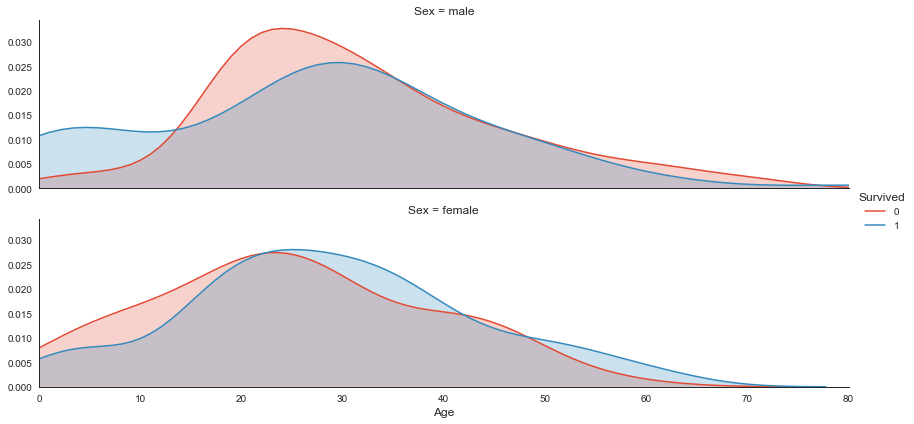

Embarked : C = Cherbourg, Q = Queenstown, S = Southampton

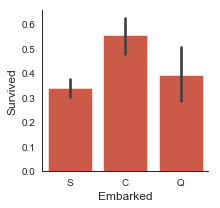

# 数据预处理

In [7]:
targets = train.Survived
train.drop(['Survived'], 1, inplace=True)
full = train.append(test, ignore_index=True)
full.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
## 规一化数字特征

## 填充空值

In [9]:
# ### 使用 RandomForestClassifier 填补缺失的年龄属性
# def set_missing_ages(df):

#     # 把已有的数值型特征取出来丢进Random Forest Regressor中
#     age_df = df[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]

#     # 乘客分成已知年龄和未知年龄两部分
#     known_age = age_df[age_df.Age.notnull()].as_matrix()
#     unknown_age = age_df[age_df.Age.isnull()].as_matrix()

#     # y即目标年龄
#     y = known_age[:, 0]

#     # X即特征属性值
#     X = known_age[:, 1:]

#     # fit到RandomForestRegressor之中
#     rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
#     rfr.fit(X, y)

#     # 用得到的模型进行未知年龄结果预测
#     predictedAges = rfr.predict(unknown_age[:, 1::])

#     # 用得到的预测结果填补原缺失数据
#     df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 

#     return df, rfr

# def set_Cabin_type(df):
#     df.loc[ (df.Cabin.notnull()), 'Cabin' ] = "Yes"
#     df.loc[ (df.Cabin.isnull()), 'Cabin' ] = "No"
#     return df

# data_train, rfr = set_missing_ages(data_train)
# data_train = set_Cabin_type(data_train)

In [10]:
# Create dataset
imputed = pd.DataFrame()

# Fill missing values of Age with the average of Age (mean)
# imputed['Age'] = full.Age.fillna(full.Age.mean())
full.Age = full.Age.fillna(full.Age.mean())

# Fill missing values of Fare with the average of Fare (mean)
# imputed['Fare'] = full.Fare.fillna(full.Fare.mean())
full.Fare = full.Fare.fillna(full.Fare.mean())

full.Embarked = full.Embarked.fillna(full.Embarked.mode())

# imputed.head()
full[full.Age.isnull().values==True]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [11]:
# 初始化一个 scaler，并将它施加到特征上
scaler = StandardScaler()
numerical = ['Age', 'Fare']
age_scale_param = scaler.fit(full[numerical])
full[numerical] = scaler.fit_transform(full[numerical])

## 独热编码

In [12]:
pclass = pd.get_dummies(full['Pclass'], prefix='Pclass')

sex = pd.get_dummies(full['Sex'], prefix='Sex')

embarked = pd.get_dummies(full['Embarked'], prefix='Embarked')

# 特征工程

In [13]:
title = pd.DataFrame()
# we extract the title from each name
title['Title'] = full['Name'].map(lambda name: name.split(',')[1].split( '.' )[0].strip())

# a map of more aggregated titles
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"
                    }

# we map each title
title['Title'] = title.Title.map(Title_Dictionary)
title = pd.get_dummies(title.Title)
#title = pd.concat([ title , titles_dummies] , axis = 1)

title.head()

,Master,Miss,Mr,Mrs,Officer,Royalty
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,0,0,1,0,0
4,0,0,1,0,0,0


Create family size and category for family size

In [14]:
family = pd.DataFrame()

# introducing a new feature : the size of families (including the passenger)
family['FamilySize'] = full['Parch'] + full['SibSp'] + 1

# introducing other features based on the family size
family['Family_Single'] = family['FamilySize'].map(lambda s : 1 if s == 1 else 0)
family['Family_Small'] = family['FamilySize'].map(lambda s : 1 if 2 <= s <= 4 else 0)
family['Family_Large'] = family['FamilySize'].map(lambda s : 1 if 5 <= s else 0)

family.head()

,FamilySize,Family_Single,Family_Small,Family_Large
0,2,0,1,0
1,2,0,1,0
2,1,1,0,0
3,2,0,1,0
4,1,1,0,0


solve Ticket

In [15]:
def cleanTicket(ticket):
    ticket = ticket.replace( '.' , '' )
    ticket = ticket.replace( '/' , '' )
    ticket = ticket.split()
    ticket = map( lambda t : t.strip() , ticket )
    ticket = list(filter( lambda t : not t.isdigit() , ticket ))
    if len( ticket ) > 0:
        return ticket[0]
    else: 
        return 'XXX'

ticket = pd.DataFrame()

# Extracting dummy variables from tickets:
ticket['Ticket'] = full['Ticket'].map(cleanTicket)
ticket = pd.get_dummies(ticket['Ticket'], prefix = 'Ticket')

ticket.shape
ticket.head()

,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,...,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


solve Cabin

In [16]:
cabin = pd.DataFrame()

# replacing missing cabins with U (for Uknown)
cabin['Cabin'] = full.Cabin.fillna('U')

# mapping each Cabin value with the cabin letter
cabin['Cabin'] = cabin['Cabin'].map(lambda c : c[0])

# dummy encoding ...
cabin = pd.get_dummies(cabin['Cabin'], prefix = 'Cabin')

cabin.head()

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1


Create datasets

In [17]:
df = pd.concat([full, pclass, sex, embarked, title, family, ticket, cabin], axis=1)
df.drop(['Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)
# df = pd.concat([imputed, embarked, cabin, sex], axis=1)
df.head()

,PassengerId,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,Ticket_XXX,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,1,-0.611972,-0.503595,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,0.630431,0.734503,1,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,3,-0.301371,-0.490544,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,0.397481,0.382925,1,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,5,0.397481,-0.488127,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1


In [18]:
# 将'features'和'income'数据切分成训练集和测试集
X_train = df[:891]
y_train = targets
X_test = df[891:]

# 将'X_train'和'y_train'进一步切分为训练集和验证集
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify = y_train)

# 显示切分的结果
print ("Training set has {} samples.".format(X_train.shape[0]))
# print ("Validation set has {} samples.".format(X_val.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 891 samples.
Testing set has 418 samples.


In [19]:
# plot_variable_importance(X_train, y_train)

特征选择

In [20]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(X_train, y_train)

In [21]:
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

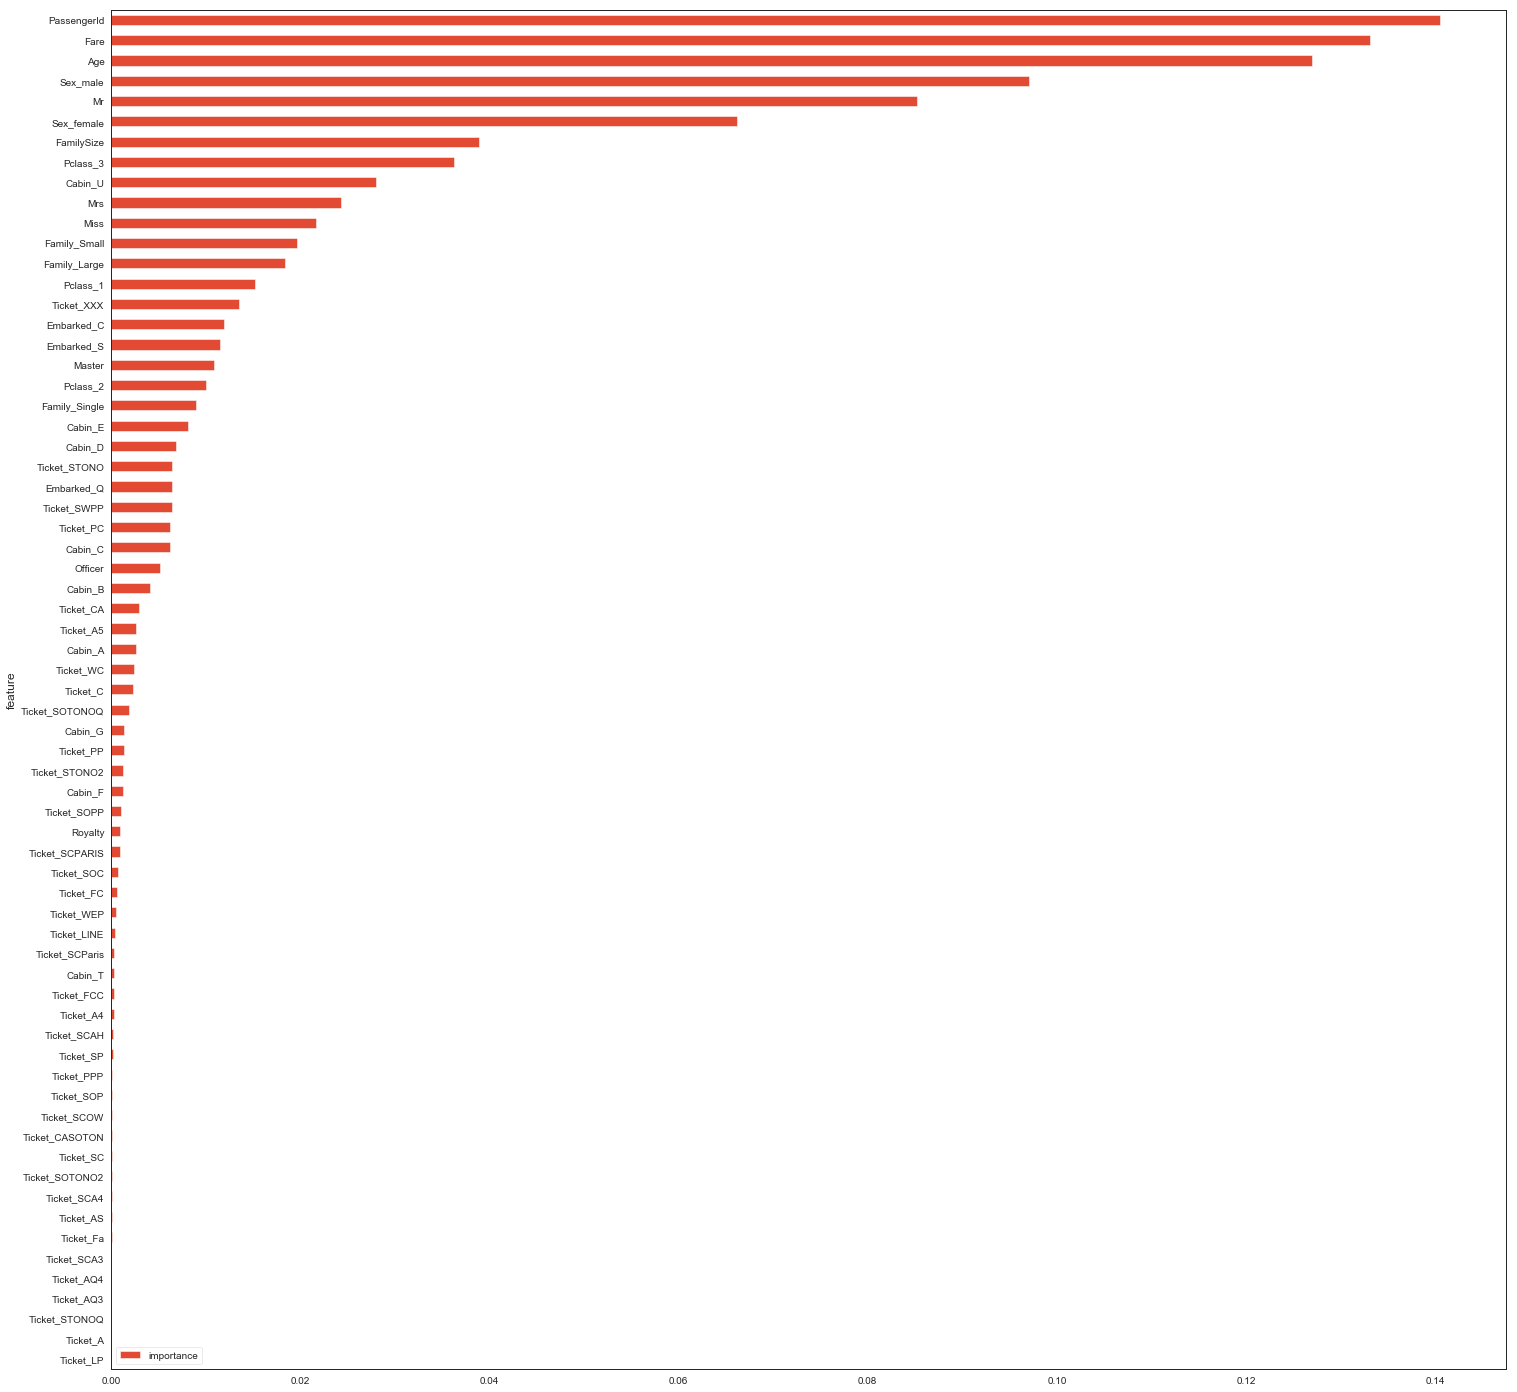

In [22]:
features.plot(kind='barh', figsize=(25, 25))

In [23]:
model = SelectFromModel(clf, prefit=True)
train_reduced = model.transform(X_train)
print (train_reduced.shape)

(891, 14)


In [24]:
test_reduced = model.transform(X_test)
print (test_reduced.shape)

(418, 14)


In [25]:
# ### RFECV刷选特征
# model = LogisticRegression()
# model.fit(X_train, y_train)
# print (model.score(X_train, y_train) , model.score(X_val, y_val))
# rfecv = RFECV(estimator=model, step=1 , cv=StratifiedKFold(2), scoring='accuracy')
# rfecv.fit(X_train, y_train)

# # print(rfecv.score(X_train , y_train), rfecv.score(X_val , y_val))
# # print("Optimal number of features : %d" % rfecv.n_features_ )

# # # Plot number of features VS. cross-validation scores
# # plt.figure()
# # plt.xlabel("Number of features selected")
# # plt.ylabel("Cross validation score (nb of correct classifications)")
# # plt.plot(range( 1 , len( rfecv.grid_scores_ ) + 1 ) , rfecv.grid_scores_)
# # plt.show()

In [26]:
### 学习曲线

# 建立模型

选择模型

In [28]:
logreg = LogisticRegression()
logreg_cv = LogisticRegressionCV()
rf = RandomForestClassifier()
gboost = GradientBoostingClassifier()

models = [logreg, logreg_cv, rf, gboost]

In [29]:
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)

In [30]:
for model in models:
    print ('Cross-validation of : {0}'.format(model.__class__))
    score = compute_score(clf=model, X=train_reduced, y=y_train, scoring='accuracy')
    print ('CV score = {0}'.format(score))
    print ('****')

Cross-validation of : <class 'sklearn.linear_model.logistic.LogisticRegression'>
CV score = 0.8170904043461439
****
Cross-validation of : <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>
CV score = 0.8170840563489371
****
Cross-validation of : <class 'sklearn.ensemble.forest.RandomForestClassifier'>
CV score = 0.8171470398296041
****
Cross-validation of : <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
CV score = 0.7847194841312481
****


模型调优

In [45]:
clf = RandomForestClassifier()
parameter_grid = {
    'max_depth' : [4, 6, 8],
    'n_estimators': [50, 10],
    'max_features': ['sqrt', 'auto', 'log2'],
    'min_samples_split': [2, 3, 10],
    'min_samples_leaf': [1, 3, 10],
    'bootstrap': [True, False]}
cross_validation = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(clf, param_grid=parameter_grid, cv=cross_validation, scoring='accuracy')

grid_search.fit(X_train, y_train)
best_clf = grid_search
parameters = grid_search.best_params_
best_predictions = best_clf.predict(X_train)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8327721661054994
Best parameters: {'bootstrap': True, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 10}


In [44]:
# 导入克隆模型的功能
from sklearn.base import clone

# 在前面的网格搜索的基础上训练一个“最好的”模型
clf_on_reduced = (clone(best_clf)).fit(train_reduced, y_train)

# 做一个新的预测
reduced_predictions = clf_on_reduced.predict(train_reduced)

# 对于每一个版本的数据汇报最终模型的分数
print ("Final Model trained on full data\n------")
print ("Accuracy on validation data: {:.4f}".format(accuracy_score(y_train, best_predictions)))
print ("F-score on validation data: {:.4f}".format(fbeta_score(y_train, best_predictions, beta = 0.5)))
print ("\nFinal Model trained on reduced data\n------")
print ("Accuracy on validation data: {:.4f}".format(accuracy_score(y_train, reduced_predictions)))
print ("F-score on validation data: {:.4f}".format(fbeta_score(y_train, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on validation data: 0.8709
F-score on validation data: 0.8492

Final Model trained on reduced data
------
Accuracy on validation data: 0.9181
F-score on validation data: 0.9142


learning curves

In [48]:
# # 用sklearn的learning_curve得到training_score和cv_score，使用matplotlib画出learning curve
# def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, 
#                         train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):
#     """
#     画出data在某模型上的learning curve.
#     参数解释
#     ----------
#     estimator : 分类器。
#     title : 表格的标题。
#     X : 输入的feature，numpy类型
#     y : 输入的target vector
#     ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
#     cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，其余n-1份作为training(默认为3份)
#     n_jobs : 并行的的任务数(默认1)
#     """
#     train_sizes, train_scores, test_scores = learning_curve(
#         estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)

#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)

#     if plot:
#         plt.figure()
#         plt.title(title)
#         if ylim is not None:
#             plt.ylim(*ylim)
#         plt.xlabel(u"number of training samples")
#         plt.ylabel(u"score")
#         plt.gca().invert_yaxis()
#         plt.grid()

#         plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
#                          alpha=0.1, color="b")
#         plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
#                          alpha=0.1, color="r")
#         plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"score on the train set")
#         plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"score on the valid set")

#         plt.legend(loc="best")

#         plt.draw()
#         plt.show()
#         plt.gca().invert_yaxis()

#     midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
#     diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
#     return midpoint, diff

# plot_learning_curve(clf, "learning curves", X_train, y_train)

取所有模型的均值

In [ ]:
# trained_models = []
# for model in models:
#     model.fit(X_train, y_train)
#     trained_models.append(model)

# predictions = []
# for model in trained_models:
#     predictions.append(model.predict_proba(X_test)[:, 1])

# predictions_df = pd.DataFrame(predictions).T
# predictions_df['out'] = predictions_df.mean(axis=1)
# predictions_df['PassengerId'] = aux['PassengerId']
# predictions_df['out'] = predictions_df['out'].map(lambda s: 1 if s >= 0.5 else 0)

# predictions_df = predictions_df[['PassengerId', 'out']]
# predictions_df.columns = ['PassengerId', 'Survived']
# predictions_df.to_csv('data/blending_base_models.csv', index=False)

# 生成结果

In [49]:
y_test = best_clf.predict(X_test).astype(int)
result = pd.DataFrame({'PassengerId': X_test['PassengerId'], 'Survived': y_test})
result.to_csv('data/gridsearch.csv', index=False)